In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from matplotlib import cm

In [155]:
class h_kernel(object):
    def __init__(self, const=1):
        self.const = const
    def __call__(self, theta, t):
        return np.exp(-1 * self.const * theta * t) * (t > 0)

    def dtheta(self, theta, t):
        return -1 * self.const * t * self.__call__(theta, t)
    def d2theta(self, theta, t):
        return self.const * (t ** 2) * self.__call__(theta, t)
    def dt(self, theta, t):
        return -1 * self.const * theta * self.__call__(theta, t)
    def d2t(self, theta, t):
        return self.const * (theta ** 2) * self.__call__(theta, t)
    def dtheta_dt(self, theta, t):
        return -1 * self.const * t * theta * self.__call__(theta, t)
    
def y_obv(theta, t, h, sigma_epsilon):
    obv = h(theta, t) + np.sqrt(sigma_epsilon)*np.random.randn()
    return obv



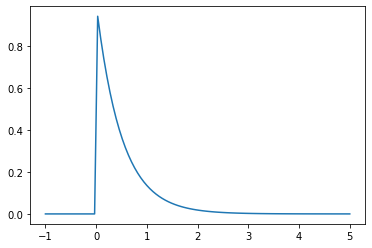

In [156]:
h = h_kernel(const=1)
xs = np.linspace(-1, 5, 100)
ys = [h(theta=2, t=t) for t in xs]
plt.plot(xs, ys)

In [157]:
def get_sigma(mu_old, sigma_prior, t, sigma_epsilon, h=h):
    J = h.dtheta(mu_old, t)
    left_term = 1 / sigma_prior
    right_term = (J**2) / sigma_epsilon

    return 1 / (left_term + right_term)

def get_mu(mu_old, sigma_current, y, mu_prior, sigma_prior,
           t, sigma_epsilon, h=h):
    J = h.dtheta(mu_old, t)
    left_term = (J * (y - h(mu_old, t))) / sigma_epsilon
    right_term = (mu_prior - mu_old) / sigma_prior
    
    return mu_old + sigma_current * (left_term + right_term)


In [182]:
def run_VI(theta_true, t, mu_prior, sigma_prior, h, num_iter=1000):
    sigma_epsilon = 1e-3 # Variance of observation noise
    y = y_obv(theta_true, t, h, sigma_epsilon)

    mu_list, sigma_list = [mu_prior], [sigma_prior]
    mu_i, sigma_i = mu_prior, sigma_prior

    for _ in range(num_iter):
        sigma_i = get_sigma(mu_i, sigma_prior, t, sigma_epsilon=sigma_epsilon, h=h)
        mu_i = get_mu(mu_i, sigma_i, y, mu_prior, sigma_prior, t, sigma_epsilon=sigma_epsilon, h=h)

        mu_list.append(mu_i)
        sigma_list.append(sigma_i)

    return mu_list, sigma_list, y
    

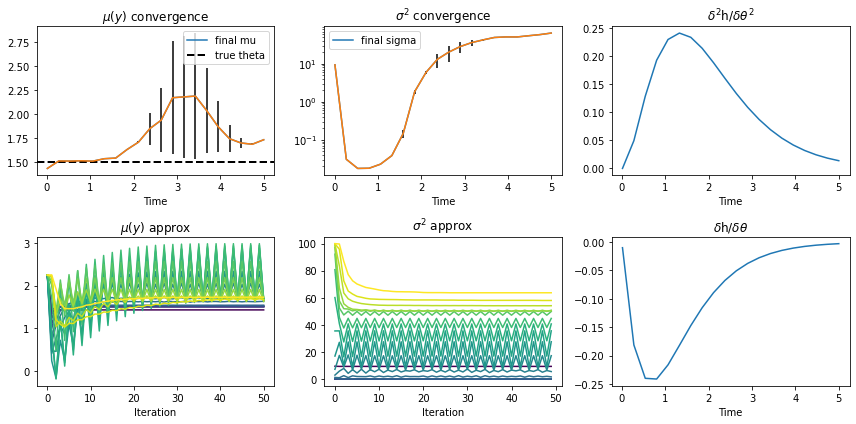

In [189]:
theta_true = 1.5

viridis = cm.get_cmap('viridis')

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
mu_final, sigma_final = list(), list()
mu_final_std, sigma_final_std = list(), list()
tmax = 5
ts = np.linspace(0.01, tmax, 20)
for t in ts:
    color = viridis(t / tmax)
    mu_prior = theta_true * 1.5
    sigma_prior = 100

    mu_list, sigma_list = list(), list()
    for _ in range(1000):
        mu_out, sigma_out, y = run_VI(theta_true, t, mu_prior, sigma_prior, h, num_iter=50)
        mu_list.append(mu_out)
        sigma_list.append(sigma_out)


    mu_avg = np.mean(mu_list, axis=0)
    sigma_avg = np.mean(sigma_list, axis=0)

    # mu_final.append(mu_avg[-1])
    # sigma_final.append(sigma_avg[-1])

    mu_final.append(np.mean(mu_avg[-5:]))
    sigma_final.append(np.mean(sigma_avg[-5:]))

    mu_final_std.append(np.std(mu_avg[-5:]))
    sigma_final_std.append(np.std(sigma_avg[-5:]))


    ax[1, 0].plot(np.array(mu_avg), label=f'True mu: {theta_true}', color=color)
    ax[1, 1].plot(np.array(sigma_avg[1:]), label=f'True mu: {theta_true}', color=color)

ax[1, 0].set_xlabel('Iteration')
ax[1, 1].set_xlabel('Iteration')
ax[1, 0].set_title('$\mu(y)$ approx')
ax[1, 1].set_title('$\sigma^{2}$ approx')

h_plot = h_kernel()
dthetas = [h_plot.dtheta(theta_true, t) for t in ts]
ax[1, 2].plot(ts, dthetas)
ax[1, 2].set_title('$\delta\mathrm{h} / \delta \\theta$')
ax[1, 2].set_xlabel('Time')


# Plot convergence point
ax[0,0].plot(ts, mu_final, label='final mu')
ax[0,0].errorbar(ts, mu_final, mu_final_std, ecolor='k')
ax[0,0].axhline(theta_true, linewidth=2, color='k', linestyle='--', label='true theta')
ax[0,0].legend()
ax[0,0].set_title('$\mu(y)$ convergence')
ax[0,0].set_xlabel('Time')

ax[0,1].plot(ts, sigma_final, label='final sigma')
ax[0,1].errorbar(ts, sigma_final, sigma_final_std, ecolor='k')
ax[0,1].legend()
ax[0,1].set_title('$\sigma^{2}$ convergence')
ax[0,1].set_xlabel('Time')
ax[0,1].set_yscale('log')

d2thetas = [h_plot.d2theta(theta_true, t) for t in ts]
ax[0, 2].plot(ts, d2thetas)
ax[0, 2].set_title('$\delta^{2} \mathrm{h} / \delta \\theta^{2}$')
ax[0, 2].set_xlabel('Time')
plt.tight_layout()
